C:\Users\PC00\anaconda3\envs\new\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\PC00\anaconda3\envs\new\lib\site-packages\torchaudio\backend\utils.py:64: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  'The interface of "soundfile" backend is planned to change in 0.8.0 to '


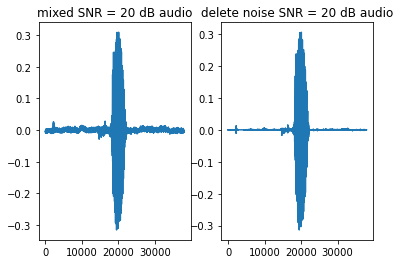

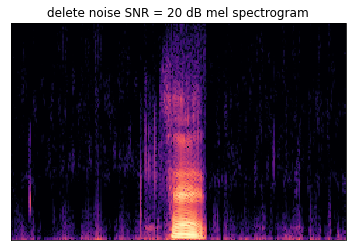

C:\Users\PC00\anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


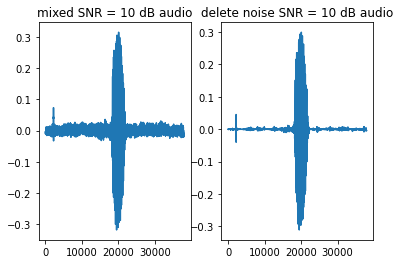

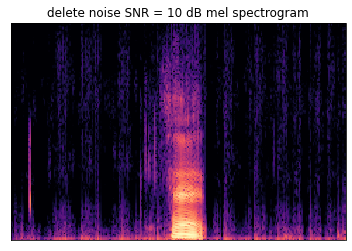

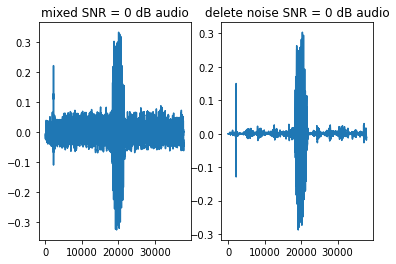

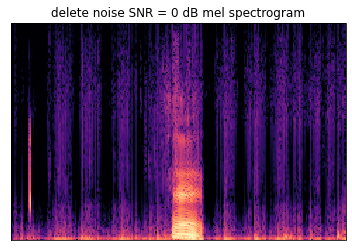

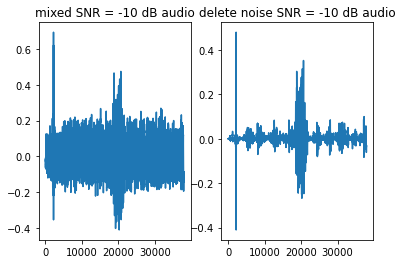

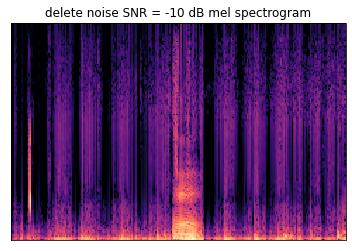

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import torchaudio
import torch
import librosa.display

def firFFT(H, order):
    NFFT = (len(H)-1)*2
    H = np.concatenate((H, np.flip(H)[1:])) + np.zeros(NFFT+1)*(1j)
    h = np.fft.ifft(H, NFFT)
    order = min(NFFT-1, order)
    delay = order//2

    h_new = np.concatenate((h[(len(h)-delay):], h[0:delay+1]))

    win = librosa.filters.get_window('hamming', len(h_new), fftbins=False)

    return (h_new * win).real


mixsnrs = np.array([20, 10, 0, -10])
for snr in mixsnrs:

    wav_path = r"./mix%ddb.wav" %snr      # mix-10db, mix0db, mix10db, mix20db
    mix_wav, sr = librosa.load(wav_path, sr=16000)    # x = mix signal
    noise_length = int(sr*0.5)
    y = mix_wav[:noise_length]  # y = background noise

    Ts = 0.01   # 10 ms shift size
    Tf = 0.02   # 20 ms frame size
    Ns = int(sr*Ts)    # shift number of samples
    Nf = int(sr*Tf)    # frame number of samples
    NFFT = int(2**(np.ceil(np.log2(Nf))))
    hNo = NFFT//2+1
    order = 30

    nframe = int((noise_length-Nf)/Ns+1)
    Snn = np.zeros(hNo)
    for i in range(nframe):
        N = np.fft.fft(y[i*Ns:i*Ns+Nf], NFFT)
        N = N[:int(len(N)/2+1)]
        magN = (N*np.conj(N)).real
        Snn += magN
    Snn = Snn/nframe

    output = []

    for ii in np.arange(len(mix_wav)//Ns):

        x = mix_wav[ii*Ns:ii*Ns+Ns]
        X = np.fft.fft(x, NFFT)
        X = X[:int(len(X)/2+1)]
        Sxx = (X*np.conj(X)).real
        H = (Sxx-Snn)/Sxx
        H = np.maximum(1e-100, H)

        h = firFFT(H, order)
        # output[ii*Nf:ii*Nf+Nf] = signal.lfilter(h, [1], x)  # x_hat
        output[ii*Nf:ii*Nf+Nf] = np.convolve(x, h, mode='same')  # x_hat
    output = np.array(output)

    plt.subplot(1, 2, 1)
    plt.plot(mix_wav)
    plt.title('mixed SNR = %d dB audio' % (snr))

    plt.subplot(1, 2, 2)
    plt.plot(output)
    plt.title('delete noise SNR = %d dB audio' % (snr))
    plt.show()

    stft = librosa.stft(np.array(output), n_fft=Nf, hop_length=Ns)
    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    plt.figure()
    librosa.display.specshow(log_spectrogram, sr=sr, hop_length=Ns)
    plt.title('delete noise SNR = %d dB mel spectrogram' % (snr))
    plt.show()

    torchaudio.save('./delete_noise_from_%ddb.wav' %snr, torch.tensor(output).float().unsqueeze(0), sr)




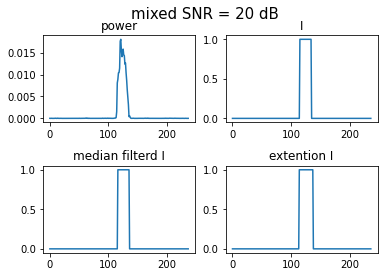

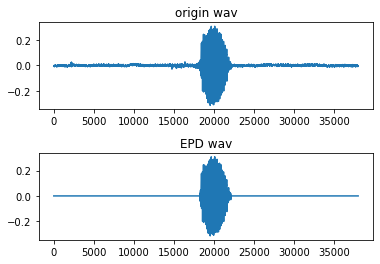

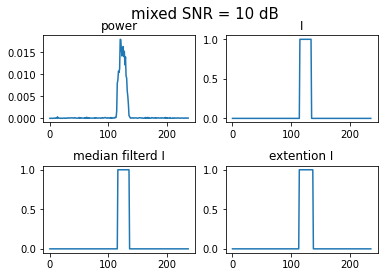

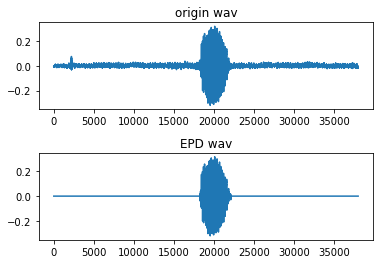

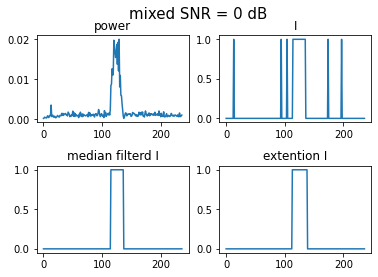

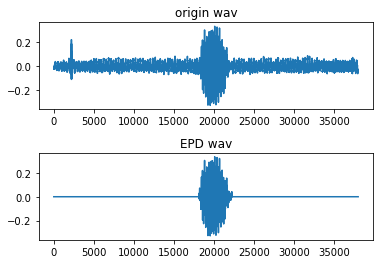

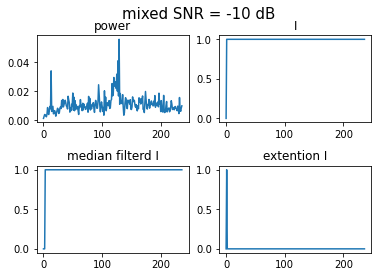

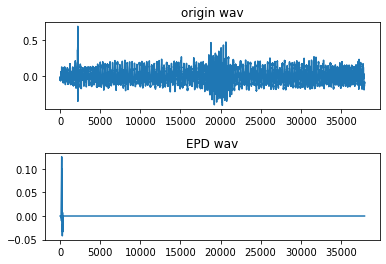

In [3]:
# EPD from energy

mixsnrs = np.array([20, 10, 0, -10])
for snr in mixsnrs:

    wav_path = r"./mix%ddb.wav" %snr      # mix-10db, mix0db, mix10db, mix20db
    mix_wav, sr = librosa.load(wav_path, sr=16000)
    u = np.zeros(len(mix_wav)//Ns)
    I = np.zeros(len(mix_wav)//Ns)


    for k in np.arange(len(mix_wav)//Ns):

        x = mix_wav[k*Ns:k*Ns+Ns]
        u[k] = sum(abs(x)**2)/Ns
        if u[k]>0.002:
            I[k] = 1
        else:
            I[k] = 0

    I_mid = np.zeros(len(I))
    for i in np.arange(len(I)):
        if i <3:
            pass
        I_mid[i] = round(sum(I[i-3:i+2])/5)

    I_ext = np.zeros(len(I))
    sp = ep = count = 0
    for i, value in enumerate(I_mid):
        if value==1 and count==0:
            sp = i
            count += 1
        elif value==1 and count>0:
            count += 1
        elif value==0 and count>0:
            ep = i
            count = 0

        I_ext[sp-2:ep+2] = 1
    
    ext_wav = np.zeros(len(mix_wav))
    ext_wav[Ns*(sp-2):Ns*(ep+2)] = mix_wav[Ns*(sp-2):Ns*(ep+2)]

    plt.suptitle('mixed SNR = %d dB'  % (snr), fontsize=15)
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(2, 2, 1)
    plt.plot(u)
    plt.title('power')

    plt.subplot(2, 2, 2)
    plt.plot(I)
    plt.title('I')
    
    plt.subplot(2, 2, 3)
    plt.plot(I_mid)
    plt.title('median filterd I')
    
    plt.subplot(2, 2, 4)
    plt.plot(I_ext)
    plt.title('extention I')    
    plt.show()
    
    
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(2,1,1)
    plt.plot(mix_wav)
    plt.title('origin wav')    
    
    plt.subplot(2,1,2)
    plt.plot(ext_wav)
    plt.title('EPD wav')    
    plt.show()